# LCA Exploratory Analysis 1 - Stats and Visualizations of Wages

Now that I have a cleaned and prepped dataset, let's poke around and see what we can learn. I'm particularly curious about the wages given to H1B applicants vs. the national average, the companies hiring the most foreigners, and what parts of the country they tend to work in.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

f = open("Prepped_LCA.csv", "r")
LCA_df = pd.read_csv(f, index_col=0)
f.close()

In [22]:
print LCA_df.dtypes

LCA_CASE_NUMBER                    object
STATUS                             object
LCA_CASE_SUBMIT                    object
DECISION_DATE                      object
LCA_CASE_EMPLOYMENT_START_DATE     object
LCA_CASE_EMPLOYMENT_END_DATE       object
LCA_CASE_EMPLOYER_NAME             object
LCA_CASE_EMPLOYER_ADDRESS          object
LCA_CASE_EMPLOYER_CITY             object
LCA_CASE_EMPLOYER_STATE            object
LCA_CASE_EMPLOYER_POSTAL_CODE       int64
LCA_CASE_SOC_CODE                  object
LCA_CASE_SOC_NAME                  object
LCA_CASE_JOB_TITLE                 object
LCA_CASE_WAGE_RATE_FROM           float64
LCA_CASE_WAGE_RATE_UNIT            object
FULL_TIME_POS                      object
LCA_CASE_WORKLOC1_CITY             object
LCA_CASE_WORKLOC1_STATE            object
PW_1                              float64
PW_UNIT_1                          object
LCA_CASE_NAICS_CODE               float64
dtype: object


I'll start by just plotting histograms of yearly and hourly wages. For the yearly wages, I'll use a log10 trasnform to normalize the distribution.

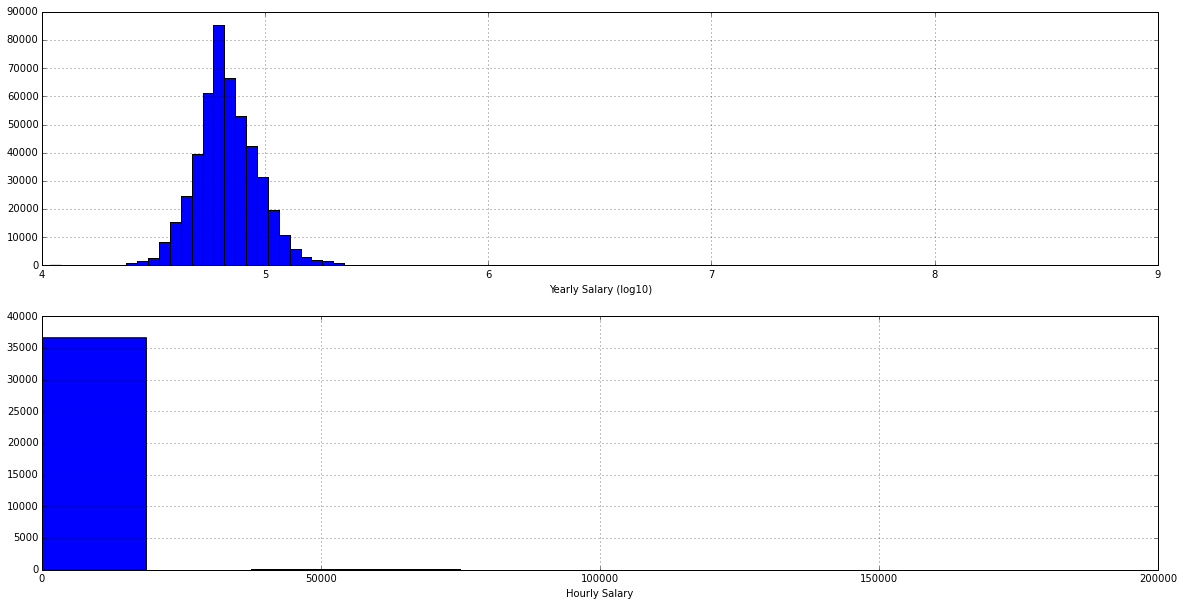

In [23]:
yearly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Year"]
hourly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Hour"]

log10_yearly_wages = np.log10(yearly_wages)  # yearly wages can vary much more than hourly ones.

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(log10_yearly_wages, bins=100)
plt.xlabel("Yearly Salary (log10)")
plt.grid(True)

plt.subplot(212)
plt.hist(hourly_wages.values, bins=10)
plt.xlabel("Hourly Salary")
plt.grid(True)

plt.show()

There are a few extreme outliers in the yearly group, which makes sense. However, the hourly wages have some values that are obviously supposed to be yearly, or are missing decimal points.

In [24]:
for index, row in LCA_df.iterrows():
    if row[20] == "Hour":
        if row[19] > 10000:  # "Hourly" wages greater than $10,000 are probably yearly. 
            LCA_df.loc[index, "PW_UNIT_1"] = "Year"
        elif row[19] > 1000:  # Wages greter than $1,000 but less than $10,000 are missing a decimal.
            LCA_df.loc[index, "PW_1"] = row[19]/100.

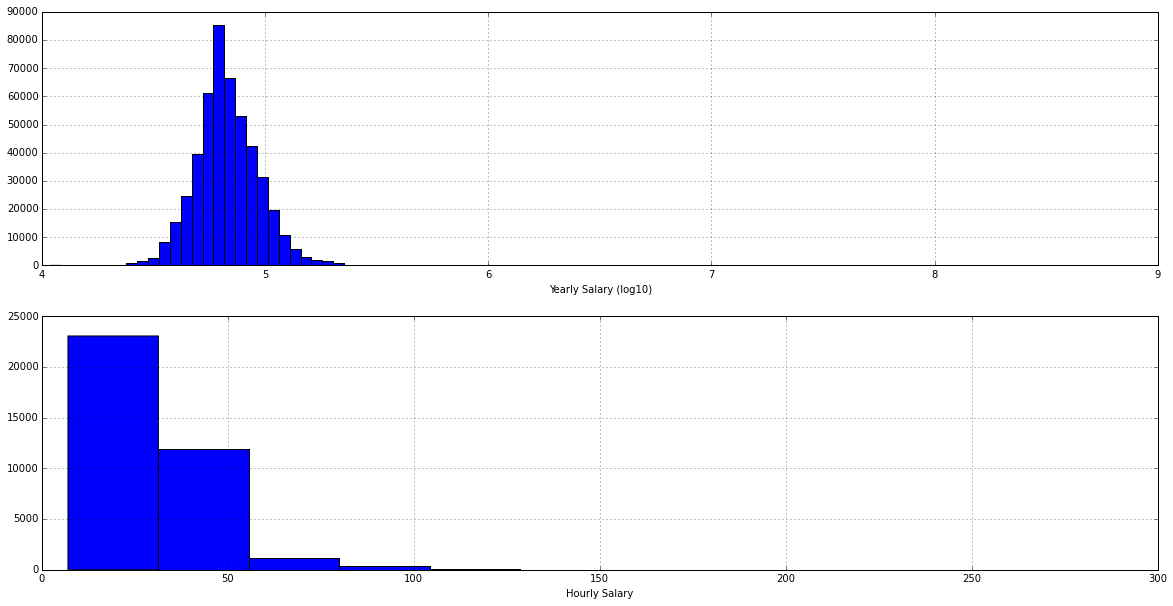

In [25]:
yearly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Year"]
hourly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Hour"]

log10_yearly_wages = np.log10(yearly_wages)  # yearly wages can vary much more than hourly ones.

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(log10_yearly_wages, bins=100)
plt.xlabel("Yearly Salary (log10)")
plt.grid(True)

plt.subplot(212)
plt.hist(hourly_wages.values, bins=10)
plt.xlabel("Hourly Salary")
plt.grid(True)

plt.show()

That looks much better. Let's try again without the top 1%.

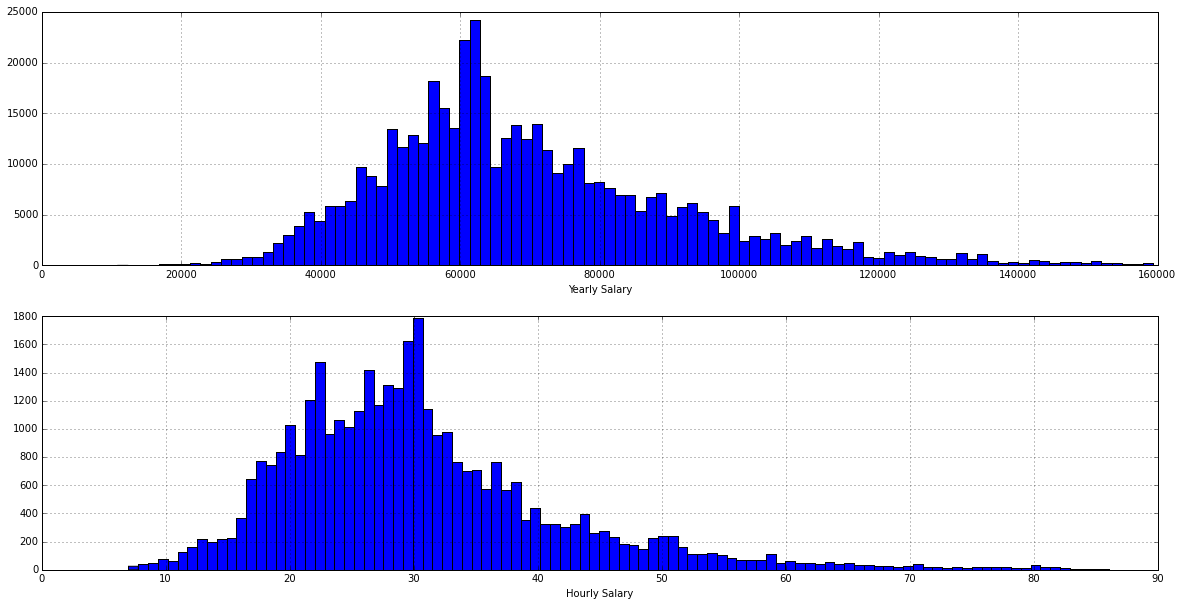

In [26]:
the_99_percent_yearly = yearly_wages[yearly_wages < yearly_wages.quantile(.99)]
the_99_percent_hourly = hourly_wages[hourly_wages < hourly_wages.quantile(.99)]

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(the_99_percent_yearly, bins=100)
plt.xlabel("Yearly Salary")
plt.grid(True)

plt.subplot(212)
plt.hist(the_99_percent_hourly.values, bins=100)
plt.xlabel("Hourly Salary")
plt.grid(True)

plt.show()

It appears that H1B applicant salaries tend to skew right. It also seems that they are paid considerably higher than the national mean of ~$43,000 anually. This is expected though, since companies wouldn't bother sponsoring just anyone to get an H1B. Though it's not fair to compare all H1B applicants to all US residents, it would be interesting to see the difference in wage when taking account of both job title and work location. For now, let's get some stats on this data to verify my observations.

In [27]:
print the_99_percent_yearly.describe() 
print the_99_percent_hourly.describe()

count    472833.000000
mean      69789.649309
std       21825.619423
min       10899.000000
25%       55370.000000
50%       65250.000000
75%       80995.000000
max      159349.000000
Name: PW_1, dtype: float64
count    36227.000000
mean        30.441881
std         11.237189
min          7.010000
25%         22.770000
50%         28.860000
75%         35.310000
max         86.080000
Name: PW_1, dtype: float64


The salaried workers are the overwhelming majority, and they make considerably more than the national average. I wonder what the typical delta between H1B wages and national averages are. I have two datasets from the Bureau of Labor Statistics, national and state, that give the wage information of each occupation (listed by SOC_CODE). I'm also going to remove the top 1% of wages from our dataset as those are most often outliers or just erroneous.

In [28]:
hour_df = LCA_df[LCA_df["PW_UNIT_1"] == "Hour"]
extreme_hours = hour_df["LCA_CASE_NUMBER"][hour_df["PW_1"] > hour_df["PW_1"].quantile(.99)]
year_df = LCA_df[LCA_df["PW_UNIT_1"] == "Year"]
extreme_years = year_df["LCA_CASE_NUMBER"][year_df["PW_1"] > year_df["PW_1"].quantile(.99)]

LCA_df = LCA_df[~LCA_df["LCA_CASE_NUMBER"].isin(extreme_hours)]  # Remove extreme hourly wages
LCA_df = LCA_df[~LCA_df["LCA_CASE_NUMBER"].isin(extreme_years)]  # Remove extreme yearly wages

f_national = open("National_2014_Wages.xlsx", "r")
f_state = open("State_2014_Wages.xlsx", "r")

national_df = pd.read_excel(f_national, na_values=["*"])  # These datasets use "*" for null values
state_df = pd.read_excel(f_state, na_values=["*", "#"])  # This one also uses "#" for extremely high values

In [29]:
print "National:", national_df.columns
print "State:", state_df.columns

National: Index([ u'OCC_CODE', u'OCC_TITLE', u'OCC_GROUP',   u'TOT_EMP',  u'EMP_PRSE',
          u'H_MEAN',    u'A_MEAN', u'MEAN_PRSE',   u'H_PCT10',   u'H_PCT25',
        u'H_MEDIAN',   u'H_PCT75',   u'H_PCT90',   u'A_PCT10',   u'A_PCT25',
        u'A_MEDIAN',   u'A_PCT75',   u'A_PCT90',    u'ANNUAL',    u'HOURLY'],
      dtype='object')
State: Index([     u'AREA',        u'ST',     u'STATE',  u'OCC_CODE', u'OCC_TITLE',
       u'OCC_GROUP',   u'TOT_EMP',  u'EMP_PRSE', u'JOBS_1000',     u'LOC_Q',
          u'H_MEAN',    u'A_MEAN', u'MEAN_PRSE',   u'H_PCT10',   u'H_PCT25',
        u'H_MEDIAN',   u'H_PCT75',   u'H_PCT90',   u'A_PCT10',   u'A_PCT25',
        u'A_MEDIAN',   u'A_PCT75',   u'A_PCT90',    u'ANNUAL',    u'HOURLY'],
      dtype='object')


I'll be performing joins using these datasets, so I need to subset them to just the columns I'll be looking at and rename them.

In [30]:
national_columns = ["OCC_CODE", "H_MEAN", "A_MEAN"]
state_columns = ["ST", "OCC_CODE", "H_MEAN", "A_MEAN"]

national_df = national_df[national_columns]
state_df = state_df[state_columns]

national_df.columns = ["SOC_CODE", "NATIONAL_H_MEAN", "NATIONAL_A_MEAN"]
state_df.columns = ["STATE", "SOC_CODE", "STATE_H_MEAN", "STATE_A_MEAN"]

In [31]:
delta_df = pd.merge(LCA_df, national_df, left_on="LCA_CASE_SOC_CODE", right_on="SOC_CODE")
delta_df = pd.merge(delta_df, state_df, left_on=["LCA_CASE_WORKLOC1_STATE", "LCA_CASE_SOC_CODE"], 
                 right_on=["STATE", "SOC_CODE"])

delta_df["NATIONAL_DELTA"] = np.nan  # add two columns to fill in
delta_df["STATE_DELTA"] = np.nan

Now that I have all the requisite data on one dataframe, I can calculate the delta as a percentile. I'm also only going to look at certified application as this point - the whole point of the LCA is to ensure fair wages.

In [32]:
delta_df["NATIONAL_DELTA"][delta_df["PW_UNIT_1"] == "Hour"] = delta_df["PW_1"]/delta_df["NATIONAL_H_MEAN"] - 1
delta_df["NATIONAL_DELTA"][delta_df["PW_UNIT_1"] == "Year"] = delta_df["PW_1"]/delta_df["NATIONAL_A_MEAN"] - 1
delta_df["STATE_DELTA"][delta_df["PW_UNIT_1"] == "Hour"] = delta_df["PW_1"]/delta_df["STATE_H_MEAN"] - 1
delta_df["STATE_DELTA"][delta_df["PW_UNIT_1"] == "Year"] = delta_df["PW_1"]/delta_df["STATE_A_MEAN"] - 1

certified_delta_df = delta_df[delta_df.STATUS.str.contains("CERTIFIED")]

print certified_delta_df.tail()

           LCA_CASE_NUMBER     STATUS      LCA_CASE_SUBMIT  \
498380  I-203-14147-001027  CERTIFIED  2014-05-27 21:33:32   
498382  I-203-14149-120922  CERTIFIED  2014-05-30 14:10:49   
498383  I-203-14258-006752  CERTIFIED  2014-09-15 14:26:23   
498385  I-203-14160-723112  CERTIFIED  2014-06-11 17:10:48   
498387  I-203-14211-765307  CERTIFIED  2014-07-30 13:29:14   

              DECISION_DATE LCA_CASE_EMPLOYMENT_START_DATE  \
498380  2014-06-02 22:01:03            2014-07-07 00:00:00   
498382  2014-06-05 22:01:51            2014-06-23 00:00:00   
498383  2014-09-19 22:01:38            2014-11-04 00:00:00   
498385  2014-06-17 22:00:33            2014-07-14 00:00:00   
498387  2014-08-07 22:00:56            2014-07-30 00:00:00   

       LCA_CASE_EMPLOYMENT_END_DATE                LCA_CASE_EMPLOYER_NAME  \
498380          2016-07-07 00:00:00                       FASHIONHAUS LLC   
498382          2014-12-31 00:00:00            SITKA CONSERVATION SOCIETY   
498383          2016-11

Looks good - now lets plot them and see what happens!

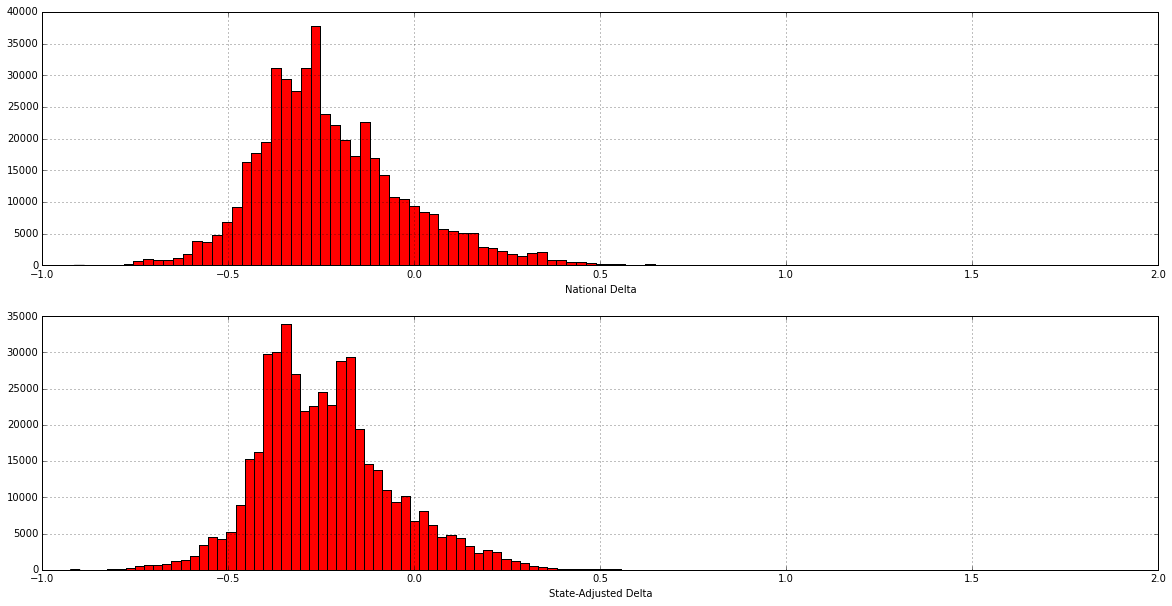

National Delta Mean: -0.224
State-Adjusted Delta Mean: -0.238


In [33]:
national_delta = certified_delta_df["NATIONAL_DELTA"].dropna()
state_delta = certified_delta_df["STATE_DELTA"].dropna()


plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(national_delta, bins=100, color = "r")
plt.xlabel("National Delta")
plt.grid(True)

plt.subplot(212)
plt.hist(state_delta.values, bins=100, color = "r")
plt.xlabel("State-Adjusted Delta")
plt.grid(True)

plt.show()

print "National Delta Mean:", round(national_delta.mean(), 3)
print "State-Adjusted Delta Mean:", round(state_delta.mean(), 3)

The H1B applicants are clearly getting paid less on average for the same job than their US resident counterparts. That said, are there any states or industries that pay foreigners particularly well? I'll use the STATE_DELTA, since it already has an additional layer of information built in.

In [34]:
delta_grouped_by_state = certified_delta_df.groupby(["STATE"])
deltas_by_state = delta_grouped_by_state["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

print deltas_by_state.head()
print deltas_by_state.tail()

STATE
AL   -0.320164
VA   -0.282052
MD   -0.278324
NM   -0.278202
NJ   -0.266567
Name: STATE_DELTA, dtype: float64
STATE
VT   -0.197550
PR   -0.193272
WI   -0.190983
SD   -0.181550
OR   -0.165384
Name: STATE_DELTA, dtype: float64


Well, Alabama seems to be the worst place to immigrate to if money is your priority. Oregon seems like a safe bet though. What about industry? 

In [35]:
# Given the nature of the data, many industry codes will be wrong.
# I'm only going to look at industries with more than 100 applicants.

delta_grouped_by_industry = certified_delta_df.groupby(["LCA_CASE_NAICS_CODE"])
valid_industries = delta_grouped_by_industry.size()[delta_grouped_by_industry.size() > 100].keys()

valid_industry_df = certified_delta_df[certified_delta_df["LCA_CASE_NAICS_CODE"].isin(valid_industries)]
delta_grouped_by_industry = valid_industry_df.groupby(["LCA_CASE_NAICS_CODE"])

industry_deltas = delta_grouped_by_industry["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

print industry_deltas.head()
print industry_deltas.tail()

LCA_CASE_NAICS_CODE
6221     -0.467234
611300   -0.441932
61131    -0.429452
611310   -0.413711
6211     -0.405792
Name: STATE_DELTA, dtype: float64
LCA_CASE_NAICS_CODE
334111   -0.034194
454112   -0.031209
312111   -0.029513
42343    -0.024056
316219    0.092502
Name: STATE_DELTA, dtype: float64


Shockingly enough, NAICS Code 6221, the bottom of the list, corresponds to "General Medical and Surgical Hospitals". My best guess at this point is that many doctors from foreign countries are willing to take a considerably pay cut to move to the US (my father was actually one of these doctors some time ago). Code 6211 is related ("Offices of Physicians"), and rounding out the bottom five are different versions of "Colleges, Universities, and Professional Schools".

But what about Code 316219? It's the only industry with a positive average delta, and it beats the next best industry, "Computer and Computer Peripheral Equipment and Software Merchant Wholesalers", by a considerable margin. Even more baffling is that the code corresponds to "Other Footwear Manufacturing". Let's take a look...

In [36]:
print certified_delta_df[certified_delta_df["LCA_CASE_NAICS_CODE"] == 316219].head(10)

           LCA_CASE_NUMBER               STATUS      LCA_CASE_SUBMIT  \
126178  I-200-14206-231344            CERTIFIED  2014-08-25 13:49:38   
152271  I-200-11186-178460  CERTIFIED-WITHDRAWN  2011-11-17 17:37:27   
152273  I-200-11307-805974  CERTIFIED-WITHDRAWN  2011-11-18 16:21:54   
152276  I-200-12052-161263  CERTIFIED-WITHDRAWN  2012-03-02 18:04:52   
152296  I-200-13260-428708            CERTIFIED  2013-09-24 18:11:57   
152314  I-200-13291-900169            CERTIFIED  2013-10-22 18:46:41   
152318  I-200-13297-043958            CERTIFIED  2013-10-26 12:58:03   
152403  I-200-14022-594940            CERTIFIED  2014-02-06 15:44:41   
152437  I-200-14045-132414  CERTIFIED-WITHDRAWN  2014-02-18 15:28:16   
152439  I-200-14045-827842  CERTIFIED-WITHDRAWN  2014-02-18 15:35:44   

              DECISION_DATE LCA_CASE_EMPLOYMENT_START_DATE  \
126178  2014-08-29 22:01:41            2014-09-15 00:00:00   
152271  2014-06-25 20:57:31            2011-11-28 00:00:00   
152273  2014-02-28 18

It's Nike - which is based out of Oregon too! Remember that OR was the state with the highest delta value as well. Now this doesn't necessarily mean that Nike pays immigrant workers better than residents. Nike is by far the largest company in the state, and it's more likely that it simply pays all of its employees very well by state standards.

While we're on the topic, let's look at deltas by company. I know I'll be missing some data due to variations in company name (see "NIKE INC" vs "NIKE USA INC" above), but with the puncuation removed, I feel that I'll capture enough data to make some interesting observations. Furthermore, I'll limit this to larger companies which submitted at least 250 applications.

In [37]:
delta_grouped_by_company = certified_delta_df.groupby(["LCA_CASE_EMPLOYER_NAME"])
valid_companies = delta_grouped_by_company.size()[delta_grouped_by_company.size() > 250].keys()

valid_company_df = certified_delta_df[certified_delta_df["LCA_CASE_EMPLOYER_NAME"].isin(valid_companies)]
delta_grouped_by_company = valid_company_df.groupby(["LCA_CASE_EMPLOYER_NAME"])

company_deltas = delta_grouped_by_company["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

print company_deltas.head()
print company_deltas.tail()

LCA_CASE_EMPLOYER_NAME
NATIONAL INSTITUTES OF HEALTH HHS                 -0.490359
TRUSTEES OF THE UNIVERSITY OF PENNSYLVANIA        -0.457284
THE BOARD OF TRUSTEES OF THE LELAND STANFORD JR   -0.450817
HARVARD UNIVERSITY                                -0.446694
JOHNS HOPKINS UNIVERSITY                          -0.432097
Name: STATE_DELTA, dtype: float64
LCA_CASE_EMPLOYER_NAME
THE BOSTON CONSULTING GROUP INC    0.002637
FACEBOOK INC                       0.014375
PAYPAL INC                         0.018708
CISCO SYSTEMS INC                  0.019766
CAPGEMINI US LLC                   0.024202
Name: STATE_DELTA, dtype: float64


Research was never known to be the best-paying line of work, but it seems to be especially bad if you're trying to immigrate to the US. On the other hand, major tech companies and consultancies tend to pay well. I believe that Capgemini in particular pays well because it's headquartered in Paris and likely sends senior staff to the US to head operations here.

Nike didn't submit over 250 applications, which is why it wasn't included here, but I am curious after seeing the impact it had on its industry and state. This time, however, I'll look at both the state-adjusted delta and the national delta.

In [38]:
nike_deltas = certified_delta_df[["NATIONAL_DELTA", "STATE_DELTA"]][certified_delta_df["LCA_CASE_EMPLOYER_NAME"]
                                                                    .str.contains("NIKE")]

print nike_deltas.mean()

NATIONAL_DELTA   -0.005109
STATE_DELTA       0.105907
dtype: float64


Nike certainly pays very well compared to other companies in Oregon, but even on a national level, it pays H1B applicants within a percent of the average for their job type.

Finally, let's look at the acutal jobs themselves and see what the deltas look like. I'll set the minimum number of data points to be 100.

In [39]:
delta_grouped_by_job = certified_delta_df.groupby(["LCA_CASE_SOC_NAME"])
valid_jobs = delta_grouped_by_job.size()[delta_grouped_by_job.size() > 100].keys()

valid_job_df = certified_delta_df[certified_delta_df["LCA_CASE_SOC_NAME"].isin(valid_jobs)]
delta_grouped_by_job = valid_job_df.groupby(["LCA_CASE_SOC_NAME"])

job_deltas = delta_grouped_by_job["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

print job_deltas.head()
print job_deltas.tail()

LCA_CASE_SOC_NAME
Physicians and Surgeons, All Other           -0.562955
Biochemists and Biophysicists                -0.468912
Physicists                                   -0.458985
Medical Scientists, Except Epidemiologists   -0.448896
Personal Financial Advisors                  -0.434451
Name: STATE_DELTA, dtype: float64
LCA_CASE_SOC_NAME
Information Security Analysts          -0.152114
Computer User Support Specialists      -0.137158
Pharmacists                            -0.136056
Legal Support Workers, All Other       -0.126844
Geological and Petroleum Technicians   -0.090646
Name: STATE_DELTA, dtype: float64


This is really interesting. Doctors and Surgeons are typically making less than half of their domestic counterparts! With the exception of Personal Financial Advisors, all of the bottom five occupations require a doctorate. Compare with the top five, which don't (with the exception of Pharmacists - interesting how they avoid the pay drop of other medical professionals).

Why is this? That would be another project on its own, but my guess is that for very high-skill professions, H1B applicants prioritize immigrating to the US and accept massive pay-cuts. Their domestic counterparts, who don't require sponsorship to come to the US, go on to command much higher salaries.

At this point, I believe I've looked at the wage information enough. I made some very interesting discoveries (particularly the deltas by job), but it's time to look at some other aspects of the data. Let's wrap up by writing the original delta dataframe to a csv for storage (the one with denied and withdrawn applications included).

In [40]:
delta_df.to_csv("Delta_LCA.csv", encoding="utf-8")